### Objective: Analyze demand distribution across categories and stores to design scalable modeling groups.
#### Key Steps:
- Identified top 20 third-level categories globally and top 5 per store.
- Found 87 unique categories cover 83.1% of demand.
- Mapped each of these top categories to associated store IDs for selective model training.

In [1]:
from datasets import load_dataset

# Load the full dataset
dataset = load_dataset("Dingdong-Inc/FreshRetailNet-50K")

# Check available splits
print(dataset)

/Users/jhilmitasri/Repositories/MyRepositories/freshretail-demand-forecasting/env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DatasetDict({
    train: Dataset({
        features: ['city_id', 'store_id', 'management_group_id', 'first_category_id', 'second_category_id', 'third_category_id', 'product_id', 'dt', 'sale_amount', 'hours_sale', 'stock_hour6_22_cnt', 'hours_stock_status', 'discount', 'holiday_flag', 'activity_flag', 'precpt', 'avg_temperature', 'avg_humidity', 'avg_wind_level'],
        num_rows: 4500000
    })
    eval: Dataset({
        features: ['city_id', 'store_id', 'management_group_id', 'first_category_id', 'second_category_id', 'third_category_id', 'product_id', 'dt', 'sale_amount', 'hours_sale', 'stock_hour6_22_cnt', 'hours_stock_status', 'discount', 'holiday_flag', 'activity_flag', 'precpt', 'avg_temperature', 'avg_humidity', 'avg_wind_level'],
        num_rows: 350000
    })
})


In [2]:
df = dataset["train"].to_pandas()

In [3]:
df.to_csv("fresh_retail_net_full.csv", index=False)

In [4]:
from datasets import load_dataset

# Stream if you're tight on RAM
dataset = load_dataset("Dingdong-Inc/FreshRetailNet-50K", split="train", streaming=True)

# Take a few thousand rows for now
batch = []
for i, row in enumerate(dataset):
    batch.append(row)
    if i == 10000:
        break

import pandas as pd
df = pd.DataFrame(batch)

In [6]:
!pip install datasets

In [7]:
from datasets import load_dataset

dataset = load_dataset("Dingdong-Inc/FreshRetailNet-50K", split="train")
df = dataset.to_pandas()

In [8]:
# Analyze number of products per third_category_id
products_per_category = df.groupby('third_category_id')['product_id'].nunique().reset_index(name='unique_products')

# Analyze number of stores carrying each third_category_id
stores_per_category = df.groupby('third_category_id')['store_id'].nunique().reset_index(name='unique_stores')

# Merge both for comparison
category_analysis = products_per_category.merge(stores_per_category, on='third_category_id')

# Display top rows
print(category_analysis.head())

   third_category_id  unique_products  unique_stores
0                  0                4             42
1                  1                4            510
2                  2                4            409
3                  3                3             34
4                  4                1             50


In [10]:
category_analysis = df.groupby('third_category_id').agg(
    unique_products=('product_id', 'nunique'),
    unique_stores=('store_id', 'nunique')
).reset_index()

In [12]:
category_analysis = df.groupby('third_category_id').agg(
    unique_products=('product_id', 'nunique'),
    unique_stores=('store_id', 'nunique')
).reset_index()

In [14]:
category_analysis

,third_category_id,unique_products,unique_stores
0,0,4,42
1,1,4,510
2,2,4,409
3,3,3,34
4,4,1,50
...,...,...,...
228,228,1,39
229,229,8,346
230,230,5,399
231,231,2,203


/var/folders/8r/40hwn8294818myg3mdy2xp0c0000gn/T/ipykernel_68948/2829494835.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=category_store_counts.sort_values(by='num_stores', ascending=False).head(20),


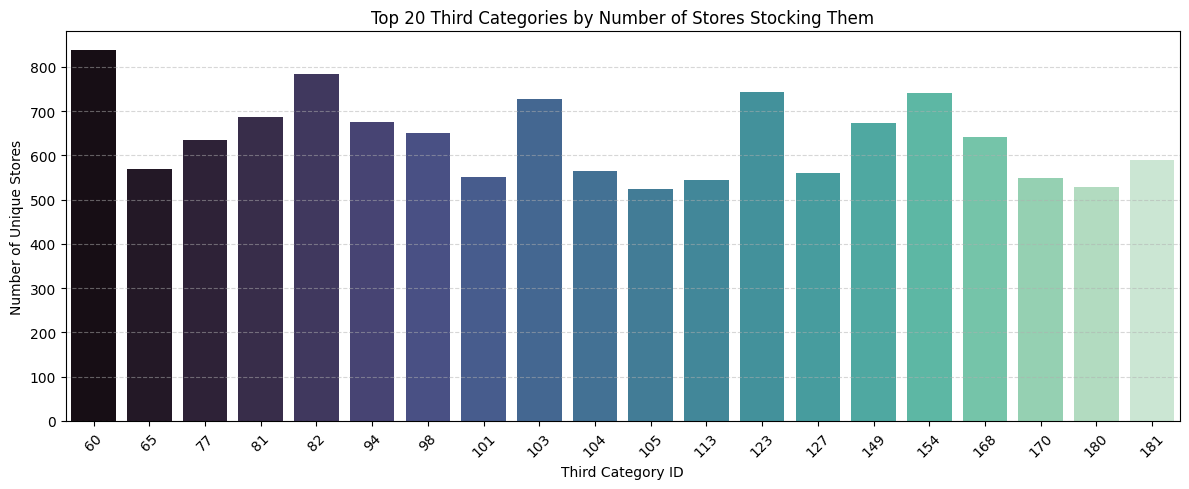

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
# Count how many stores carry each third_category_id
category_store_counts = df.groupby('third_category_id')['store_id'].nunique().reset_index()
category_store_counts.columns = ['third_category_id', 'num_stores']

# Visualize
plt.figure(figsize=(12, 5))
sns.barplot(data=category_store_counts.sort_values(by='num_stores', ascending=False).head(20),
            x='third_category_id', y='num_stores', palette='mako')
plt.title('Top 20 Third Categories by Number of Stores Stocking Them')
plt.xlabel('Third Category ID')
plt.ylabel('Number of Unique Stores')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

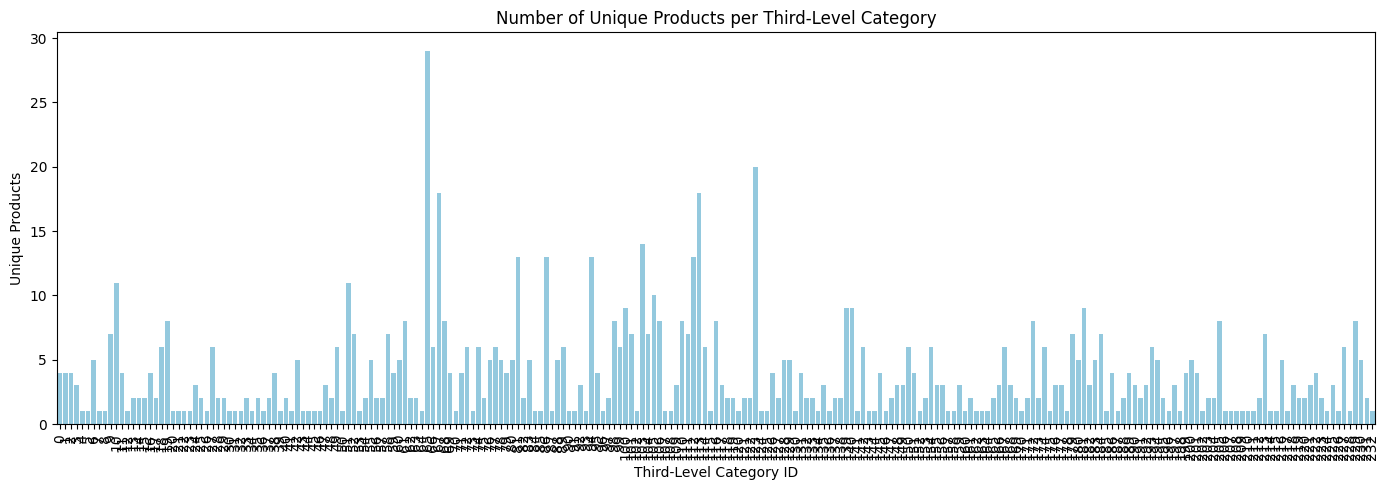

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count unique products per category
product_counts = category_analysis.groupby('third_category_id')['unique_products'].sum().sort_values(ascending=False)

plt.figure(figsize=(14, 5))
sns.barplot(x=product_counts.index, y=product_counts.values, color='skyblue')
plt.title('Number of Unique Products per Third-Level Category')
plt.xlabel('Third-Level Category ID')
plt.ylabel('Unique Products')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

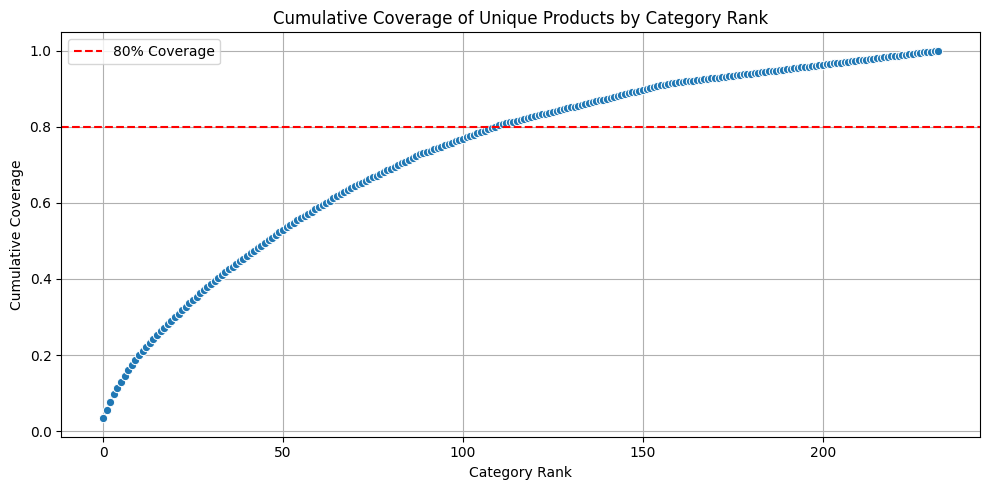

In [19]:
# Compute cumulative product coverage
cumulative = product_counts.cumsum() / product_counts.sum()

plt.figure(figsize=(10, 5))
sns.lineplot(x=range(len(cumulative)), y=cumulative.values, marker='o')
plt.axhline(0.8, color='red', linestyle='--', label='80% Coverage')
plt.title('Cumulative Coverage of Unique Products by Category Rank')
plt.xlabel('Category Rank')
plt.ylabel('Cumulative Coverage')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()